In [ ]:
%%time
!cp "/content/drive/My Drive/reddragon_spectrograms.zip" "reddragon_spectrograms.zip"
!unzip "reddragon_spectrograms.zip" 

^C
Archive:  reddragon_spectrograms.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of reddragon_spectrograms.zip or
        reddragon_spectrograms.zip.zip, and cannot find reddragon_spectrograms.zip.ZIP, period.
CPU times: user 71.8 ms, sys: 20.9 ms, total: 92.7 ms
Wall time: 39.3 s


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#CNN model training and evaluation

Using spectrograms to classify speakers. 

40 speakers: 95% val accuracy. 

80 speakers: 85% val accuracy

115 speakers: 78% val accuracy. 

Using triplet loss with the penultimate latent vector revealed that the model was unable to extrapolate to unseen speakers.

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *

In [ ]:
clip_info = pd.read_csv("/content/drive/My Drive/clip_info_finalest.csv")

classes = clip_info.speaker_id.unique()
classes = classes[0:112]
num_classes = len(classes)
num_classes

In [ ]:
%%time
'''
clip_info['count'] = 0
from PIL import Image
from collections import defaultdict 

counter = defaultdict(lambda:0)

root = "/content/reddragon/"
for i in range(len(clip_info)):
  row = clip_info.iloc[i]
  speaker = str(row["speaker_id"])
  
  counter[speaker] += 1
  clip_info.loc[i, "count"] = counter[speaker]
 
'''
'''
%%time
from PIL import Image
from collections import defaultdict 

counter = defaultdict(lambda:0)

root = "/content/reddragon/"
for i in range(len(clip_info)):
  row = clip_info.iloc[i]
  speaker = str(row["speaker_id"])
  count = str(row["count"])

  clip_info.loc[i, "final_path"] = "/content/content/drive/My Drive/reddragon/spectrograms/" + speaker + "/" + count + ".npy"
'''
  

In [ ]:

root = "/content/content/drive/My Drive/reddragon/spectrograms/"
train_df = pd.DataFrame(columns=clip_info.columns)
test_df = pd.DataFrame(columns=clip_info.columns)
test_pct = 0.1
for classi in classes:
  
  class_exs = clip_info[clip_info['speaker_id'] == int(classi)].reset_index(drop=True)
  num_exs = class_exs.shape[0]
  train_num = int((1-test_pct) * num_exs)
  
  train_exs = class_exs.iloc[:train_num]
  test_exs = class_exs.iloc[train_num:]
  if test_exs.shape[0] == 0:
    print(num_exs)
    print(train_num)
    print(classi)

  train_df = pd.concat([train_df, train_exs])
  test_df = pd.concat([test_df, test_exs])

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import Adam
def build_cnn_model(num_classes):

  inp = Input((128, 378, 1))
  x = Conv2D(filters=16, kernel_size=2, activation='relu')(inp)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.2)(x)

  x = Conv2D(filters=32, kernel_size=2, activation='relu')(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.2)(x)


  x = Conv2D(filters=64, kernel_size=2, activation='relu')(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.2)(x)

  x = Conv2D(filters=128, kernel_size=2, activation='relu')(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.2)(x)
  x = GlobalAveragePooling2D()(x)

  out = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs=inp, outputs=out)

  model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
  print(model.summary())
  return model


In [ ]:
import tensorflow as tf
import numpy as np

def get_spec(filename, data_mean=-26.533236022216165, spec_width=378):
  fn = bytes.decode(filename.numpy())
  spec = np.load(fn)
  spec /= data_mean

  num_times = spec_width // spec.shape[1]
  
  if num_times != 0:
    leftover = spec_width - num_times * spec.shape[1]

    spec = np.repeat(spec, num_times, axis=1)
    
    spec = np.concatenate([spec, spec[:,:leftover]], axis=1)
  else:
    spec = spec[:,:spec_width]

  
  spec = np.expand_dims(spec, axis=2)
  

  return spec

def _parse_function(filename, label):
  
  spec = tf.py_function(get_spec, [filename], tf.float64)
  spec = tf.ensure_shape(spec ,shape=(128, 378, 1))
  label = tf.ensure_shape(label ,shape=(num_classes))
  
  
  return spec, label

batch_size=16

train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(train_df['final_path'].values, tf.string),
                                                    tf.cast(train_labels.values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(test_df['final_path'].values, tf.string),
                                                    tf.cast(test_labels.values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
model = build_cnn_model(num_classes)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 378, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 377, 16)      80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 188, 16)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 63, 188, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 187, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 93, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 93, 32)       

In [ ]:
from tensorflow.keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0002)
history = model.fit( train_dataset, 
                    steps_per_epoch = train_df.shape[0]//16,
                   epochs = 8,
                   validation_data = valid_dataset,
                   validation_steps = test_df.shape[0]//16)

Epoch 1/8
703/703 [==============================] - 148s 210ms/step - loss: 0.5266 - accuracy: 0.8442 - val_loss: 0.9771 - val_accuracy: 0.7199
Epoch 2/8
703/703 [==============================] - 147s 209ms/step - loss: 0.5226 - accuracy: 0.8436 - val_loss: 0.9974 - val_accuracy: 0.7199
Epoch 3/8
703/703 [==============================] - 148s 210ms/step - loss: 0.5029 - accuracy: 0.8548 - val_loss: 0.7973 - val_accuracy: 0.7809
Epoch 4/8
703/703 [==============================] - 147s 209ms/step - loss: 0.5016 - accuracy: 0.8509 - val_loss: 0.8528 - val_accuracy: 0.7600
Epoch 5/8
703/703 [==============================] - 147s 209ms/step - loss: 0.4719 - accuracy: 0.8620 - val_loss: 0.7883 - val_accuracy: 0.7647
Epoch 6/8
703/703 [==============================] - 147s 209ms/step - loss: 0.4688 - accuracy: 0.8585 - val_loss: 0.7767 - val_accuracy: 0.7739
Epoch 7/8
703/703 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.8654

In [ ]:
model.save("/content/drive/My Drive/115voices_vanillacnn.h5")
from tensorflow import keras
model = keras.models.load_model("/content/drive/My Drive/115voices_vanillacnn.h5")
kout = Dense(150, activation='softmax')(model.layers[-2].output)

non_class1 = clip_info[clip_info.speaker_id ==int(non_classes[0])].reset_index(drop=True)
non_class2 = clip_info[clip_info.speaker_id ==int(non_classes[1])].reset_index(drop=True)
non_class3 = clip_info[clip_info.speaker_id ==int(non_classes[2])].reset_index(drop=True)

n1 = get_spec_norm(non_class1.loc[0, 'final_path'])
n2 = get_spec_norm(non_class1.loc[1, 'final_path'])
n3 = get_spec_norm(non_class1.loc[2, 'final_path'])

o1 = get_spec_norm(non_class3.loc[0, 'final_path'])
o2 = get_spec_norm(non_class3.loc[1, 'final_path'])
o3 = get_spec_norm(non_class3.loc[2, 'final_path'])


m1 = get_spec_norm(non_class2.loc[0, 'final_path'])
m2 = get_spec_norm(non_class2.loc[1, 'final_path'])
m3 = get_spec_norm(non_class2.loc[2, 'final_path'])

np.linalg.norm(dummy_model(np.expand_dims(o2, axis=0))-dummy_model(np.expand_dims(n3, axis=0)))

#Tabular model training and evaluation

Using tabular features to classify speakers. 

150 speakers: 99.5% val accuracy. 

Using triplet loss with the penultimate layer revealed that the latent vector could extrapolate to a holdout set of 101 speakers with an accuracy of 70% without training. (Fine-tuning would probably allow it to go back to 99% val accuracy)

This suggests that a useful, but imperfect, general representation has been learned.

Training is extremely quick with this model, you can run it yourself, given the data.



In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
clip_info = pd.read_csv("/content/drive/My Drive/clip_info_finalest.csv")

classes = clip_info.speaker_id.unique()
classes = classes[0:150]
num_classes = len(classes)
num_classes

150

In [ ]:
def build_tabular(num_classes):

  inp = Input((187))
  x = Dense(193, activation='relu')(inp)
  x = Dropout(0.1)(x)

  x = Dense(128, activation='relu')(x)
  x = Dropout(0.2)(x)

  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)


  

  out = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs=inp, outputs=out)

  model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
  print(model.summary())
  return model


In [ ]:
X = np.load("/content/drive/My Drive/tab_info_complete.npy")
y = clip_info.speaker_id

In [ ]:
X = pd.DataFrame(X)
total = pd.concat([X,y], axis=1)

In [ ]:
total

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,speaker_id
0,-378.984647,116.162422,-17.332546,35.479327,-4.448054,-8.969773,-10.835938,-9.472341,-0.795535,-4.003963,-3.411418,-6.772533,-3.136346,-0.438471,-0.724784,-7.967132,-3.204955,-2.498293,-4.416882,-0.013168,-4.519273,-1.344529,-0.017705,-3.099055,-0.163226,3.991476,0.624113,1.014821,5.007116,0.611839,2.227606,3.690647,1.047732,2.435556,3.660017,3.157895,4.023052,5.619310,3.962789,3.374655,...,0.005883,0.004814,0.004310,0.004318,0.004430,0.002984,0.003827,0.006852,0.004911,0.002691,0.001568,0.002570,0.003436,0.001212,0.000665,0.000432,0.000134,0.000024,0.000004,4.885913e-07,2.752604e-08,3.310267e-10,2.096735e-10,1.028704e-10,1.084731e-10,2.539558e-10,1.981922e-10,8.486392e-10,3.387747e-10,8.125983e-10,2.940645e-10,1.915570e-10,16.781012,19.563837,20.597696,19.110058,18.907353,21.324619,40.286322,6818
1,-360.585734,109.734169,-28.806914,35.320974,-11.222565,-1.842546,-14.212534,-10.677975,1.110187,-0.334412,-3.172706,-12.516410,-1.608148,-3.096722,-1.703256,-8.087596,-3.407032,-0.335436,-6.325538,-1.191407,-2.294444,-1.416659,0.618330,1.412627,1.166945,5.897295,2.338395,1.359338,6.999274,3.117167,4.644802,3.254507,3.017500,5.550849,4.500174,5.781449,3.431529,1.439598,2.080126,-0.521632,...,0.004059,0.003550,0.005577,0.006193,0.005960,0.005229,0.004485,0.004437,0.003569,0.003476,0.004212,0.003283,0.002065,0.001380,0.001269,0.000580,0.000092,0.000033,0.000007,5.305461e-07,2.561801e-08,2.972462e-10,3.035355e-10,2.145632e-10,2.034855e-10,5.124118e-10,3.488708e-10,1.206213e-09,4.410794e-10,1.147120e-09,3.965186e-10,4.237231e-10,15.783335,20.178407,20.849809,19.250531,18.917857,20.290513,41.420199,6818
2,-385.111883,103.916242,-9.390188,31.750364,-6.380552,-5.126309,-8.498947,-9.582734,-2.340875,-5.162678,-2.530776,-6.240352,-4.714329,-1.416646,-0.342624,-6.329395,-1.965251,-3.140808,-4.357819,2.612710,-3.939102,-5.190391,-0.843375,-2.071385,-4.466790,-0.285233,-0.554399,-1.545056,2.557443,1.655296,2.597475,2.883823,3.817268,4.195601,4.166037,6.105434,4.458746,4.813243,5.400831,3.343224,...,0.003416,0.002760,0.002376,0.003159,0.004918,0.004074,0.003360,0.002468,0.002181,0.002150,0.001456,0.001187,0.002023,0.001028,0.000599,0.000219,0.000060,0.000011,0.000002,2.255360e-07,1.041009e-08,3.469450e-10,3.366587e-10,2.549752e-10,2.579850e-10,4.479804e-10,3.764807e-10,7.868146e-10,4.642241e-10,7.525490e-10,3.804914e-10,3.316418e-10,17.257269,18.635043,19.671582,18.186143,18.279153,20.241733,40.370937,6818
3,-415.985906,98.632315,-11.634932,25.853185,-5.788481,-3.137197,-4.547056,-6.224032,-0.984390,-0.944783,-3.054848,-6.775986,-1.199266,-1.846986,0.013500,-4.888008,-3.797794,-2.617675,-3.850502,-0.216068,-3.617553,-2.801673,-1.148854,-2.278221,-2.267234,1.587220,1.155384,0.740378,3.569952,2.408959,3.202875,2.306133,2.023648,2.190643,2.170674,3.525891,2.949508,3.362839,3.350881,1.972878,...,0.001296,0.001294,0.001408,0.001582,0.001426,0.001299,0.001408,0.001749,0.001651,0.001104,0.001043,0.001755,0.001912,0.000772,0.000463,0.000218,0.000077,0.000018,0.000003,4.400634e-07,3.327332e-08,3.005347e-10,1.363162e-10,8.207327e-11,8.250479e-11,2.131331e-10,1.889226e-10,5.581513e-10,2.728019e-10,5.130721e-10,2.155240e-10,1.554211e-10,16.916067,16.995845,18.250172,17.788338,17.766173,19.751291,40.690395,6818
4,-389.216203,85.664793,-12.100713,36.519470,-5.123375,-2.776924,-13.039466,-9.157566,-0.670942,-5.634273,-4.250982,-7.122923,-0.542032,-0.231418,-1.115437,-8.437816,-0.201819,0.551886,-6.287000,1.212430,-1.322355,-1.636769,-0.759968,-0.810057,1.046202,2.115052,0.084705,0.850165,2.161932,1.031209,3.371500,1.195837,1.647626,2.550498,2.289650,4.546426,4.422887,5.207331,4.847171,1.290168,...,0.007625,0.004986,0.004886,0.006394,0.005517,0.005415,0.005166,0.004006,0.003477,0.00

In [ ]:
import pandas as pd
root = "/content/content/drive/My Drive/reddragon/spectrograms/"
train_df = pd.DataFrame(columns=total.columns)
test_df = pd.DataFrame(columns=total.columns)
test_pct = 0.1
for classi in classes:
  
  class_exs = total[total['speaker_id'] == int(classi)].reset_index(drop=True)
  num_exs = class_exs.shape[0]
  train_num = int((1-test_pct) * num_exs)
  
  train_exs = class_exs.iloc[:train_num]
  test_exs = class_exs.iloc[train_num:]
  if test_exs.shape[0] == 0:
    print(num_exs)
    print(train_num)
    print(classi)

  train_df = pd.concat([train_df, train_exs])
  test_df = pd.concat([test_df, test_exs])

In [ ]:
train_X = train_df.iloc[:,:-1].values
val_X = test_df.iloc[:,:-1].values

train_y = pd.get_dummies(train_df.speaker_id).values
val_y = pd.get_dummies(test_df.speaker_id).values


In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
train_X = ss.fit_transform(train_X)
val_X = ss.transform(val_X)

In [ ]:
model = build_tabular(train_y.shape[1])


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 187)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 193)               36284     
_________________________________________________________________
dropout_15 (Dropout)         (None, 193)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               24832     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)             

In [ ]:
history = model.fit(train_X, train_y, batch_size=256, epochs=100, validation_data=(val_X, val_y))

Epoch 1/100
60/60 [==============================] - 0s 5ms/step - loss: 4.4694 - accuracy: 0.0818 - val_loss: 3.0642 - val_accuracy: 0.4400
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 2.6998 - accuracy: 0.3498 - val_loss: 1.2773 - val_accuracy: 0.8137
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 1.6045 - accuracy: 0.5758 - val_loss: 0.6302 - val_accuracy: 0.8923
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 1.0800 - accuracy: 0.7024 - val_loss: 0.3592 - val_accuracy: 0.9506
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.7854 - accuracy: 0.7806 - val_loss: 0.2323 - val_accuracy: 0.9641
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.8230 - val_loss: 0.1599 - val_accuracy: 0.9770
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.5027 - accuracy: 0.8555 - val_loss: 0.1174 - val_accuracy: 0.9804
Epoch 8/100
6

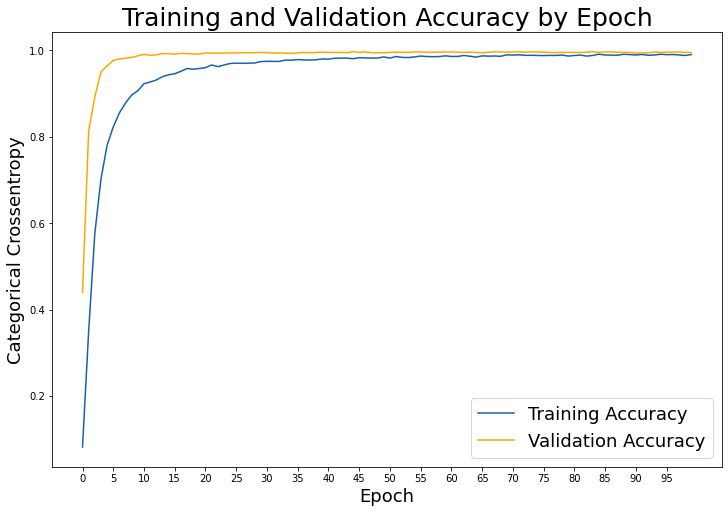

In [ ]:
import matplotlib.pyplot as plt 

# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);



In [ ]:
model.save("/content/drive/My Drive/tab_audio_classify_model.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/My Drive/tab_audio_classify_model.h5")

In [ ]:
## removing the softmax + dropout layers to extract the penultimate latent vector

dummy_model = Model(inputs=model.inputs, outputs=model.layers[-3].output)

for layer in dummy_model.layers:
  layer.trainable = False

In [ ]:
# every class that is not in the training/val set. 
non_classes = [c for c in total.speaker_id.unique() if c not in classes]

non_class1 = total[total.speaker_id == non_classes[0]].iloc[:,:-1]
non_class2 = total[total.speaker_id == non_classes[1]].iloc[:,:-1]
non_class3 = total[total.speaker_id == non_classes[2]].iloc[:,:-1]

nc1_ex1 = dummy_model(np.expand_dims(non_class1.iloc[0].values, axis=0)).numpy().flatten()
nc1_ex2 = dummy_model(np.expand_dims(non_class1.iloc[1].values, axis=0)).numpy().flatten()
nc1_ex3 = dummy_model(np.expand_dims(non_class1.iloc[2].values, axis=0)).numpy().flatten()

nc2_ex1 = dummy_model(np.expand_dims(non_class2.iloc[0].values, axis=0)).numpy().flatten()
nc2_ex2 = dummy_model(np.expand_dims(non_class2.iloc[1].values, axis=0)).numpy().flatten()
nc2_ex3 = dummy_model(np.expand_dims(non_class2.iloc[2].values, axis=0)).numpy().flatten()

nc3_ex1 = dummy_model(np.expand_dims(non_class3.iloc[0].values, axis=0)).numpy().flatten()
nc3_ex2 = dummy_model(np.expand_dims(non_class3.iloc[1].values, axis=0)).numpy().flatten()
nc3_ex3 = dummy_model(np.expand_dims(non_class3.iloc[2].values, axis=0)).numpy().flatten()

In [ ]:
## for every class in non_classes, find the latent vector representation from our model. Compare this with the representation from every other class
count = 0
for i in range(len(non_classes)):
  test_class = non_classes[i]
  test_class_exs = total[total.speaker_id == test_class].iloc[:,:-1]
  test_class_ex =  dummy_model(np.expand_dims(test_class_exs.iloc[0].values, axis=0)).numpy().flatten()

  smallest_diff = 999999999
  best_class = test_class

  for classi in non_classes:
    class_exs = total[total.speaker_id == classi].iloc[:,:-1]
    class_ex =  dummy_model(np.expand_dims(class_exs.iloc[2].values, axis=0)).numpy().flatten()

    diff = np.linalg.norm(test_class_ex-class_ex)
    if diff < smallest_diff:
      smallest_diff = diff
      best_class = classi
      
  if best_class != test_class:
    count += 1
    

In [ ]:
len(non_classes)

101

In [ ]:
100*(1-count/len(non_classes))

69.3069306930693

In [ ]:
'''
%%time
import tensorflow as tf
root = "/content/reddragon/"
for i in range(len(clip_info)):
  row = clip_info.iloc[i]
  k = np.load(row['final_path'])
  clip_info.loc[i, 'mean'] = k.mean()
'''

'\n%%time\nimport tensorflow as tf\nroot = "/content/reddragon/"\nfor i in range(len(clip_info)):\n  row = clip_info.iloc[i]\n  k = np.load(row[\'final_path\'])\n  clip_info.loc[i, \'mean\'] = k.mean()\n'

In [ ]:
data_mean = -26.533236022216165

In [ ]:
train_labels = pd.get_dummies(train_df.speaker_id)
test_labels = pd.get_dummies(test_df.speaker_id)

In [ ]:
train_labels.shape
test_labels.shape

(1337, 112)

In [ ]:
def get_spec_norm(filename, data_mean=-26.533236022216165, spec_width=378):
  spec = np.load(filename)
  spec /= data_mean

  num_times = spec_width // spec.shape[1]
  
  if num_times != 0:
    leftover = spec_width - num_times * spec.shape[1]

    spec = np.repeat(spec, num_times, axis=1)
    
    spec = np.concatenate([spec, spec[:,:leftover]], axis=1)
  else:
    spec = spec[:,:spec_width]

  
  spec = np.expand_dims(spec, axis=2)
  

  return spec